### Links to resources. Summarize briefly what's in them.

https://www.ligo.org/science/GW-Continuous.php - Introduction to LIGO & Gravitational Waves. This link was provided by the competition organizor.

https://www.kaggle.com/code/edwardcrookenden/g2net-getting-started-eda - Notebook with loading data and EDA

https://github.com/PyFstat/PyFstat/tree/1e8d6d7028309d24e08545d7610c83549468d304 - PyFstat python 3.7 repo

https://www.kaggle.com/code/rodrigotenorio/generating-continuous-gravitational-wave-signals - Data Generation from competition hosts

https://www.kaggle.com/code/ayuraj/g2net-understand-the-data - notebook gives overview of the data

https://youtu.be/T9x2rvdhaIE - good video explanation of the SFT

 https://www.kaggle.com/competitions/g2net-detecting-continuous-gravitational-waves/discussion/357533- past competition resources

# Tasks

#### at some point move notebook to colab or google cloud ai notebooks. you should figure out what's better.
#### 1) generate data and then understand the parameters.-- this can have a lot of different ways to generate data with the variety of parameters that we have.
#### 2) pre-processing - figure out the various ways to input the data into the model i.e., what transformation are available.
#### 3) model selection - which model architechtures are the best.

# Ideas

#### Maybe we should break the spectrograms into smaller pieces and train some model to predict with some probability whether there's a wave there. then somehow combine the result and predict based on this combination.

In [1]:
# this is the library for generating waves
!pip install git+https://github.com/PyFstat/PyFstat@python37 --quiet
!pip3 install timm --quiet

In [2]:
import h5py
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from timm.scheduler import CosineLRScheduler
import timm
import time

# Data Exploration

### Format of the data files

- <span style="font-family:verdana; word-spacing:1.5px;">  `ID` is the top group of the HDF5 file and links the datapoint to it's label in the `train_labels` csv  (group)

- <span style="font-family:verdana; word-spacing:1.5px;">  `frequency_Hz` contains the range frequencies measured by the dectors (dataset)


- <span style="font-family:verdana; word-spacing:1.5px;">  `H1` contains the data for the LIGO Hanford decector (group) 
    
    - <span style="font-family:verdana; word-spacing:1.5px;">  `SFTs` is the Short-time Fourier Transforms amplitudes for each timestamp at each frequency (dataset)
    - <span style="font-family:verdana; word-spacing:1.5px;">  `timestamps` contains the timestamps for the measurement (dataset)

    
- <span style="font-family:verdana; word-spacing:1.5px;">  `L1` contains the data for the LIGO Livingston decector (group) 
    
    - <span style="font-family:verdana; word-spacing:1.5px;">  `SFTs` is the Short-time Fourier Transforms amplitudes for each timestamp at each frequency (dataset)
    - <span style="font-family:verdana; word-spacing:1.5px;">  `timestamps` contains the timestamps for the measurement (dataset)    
    
<span style="font-family:verdana; word-spacing:1.5px;"> This structure can be visualised below 
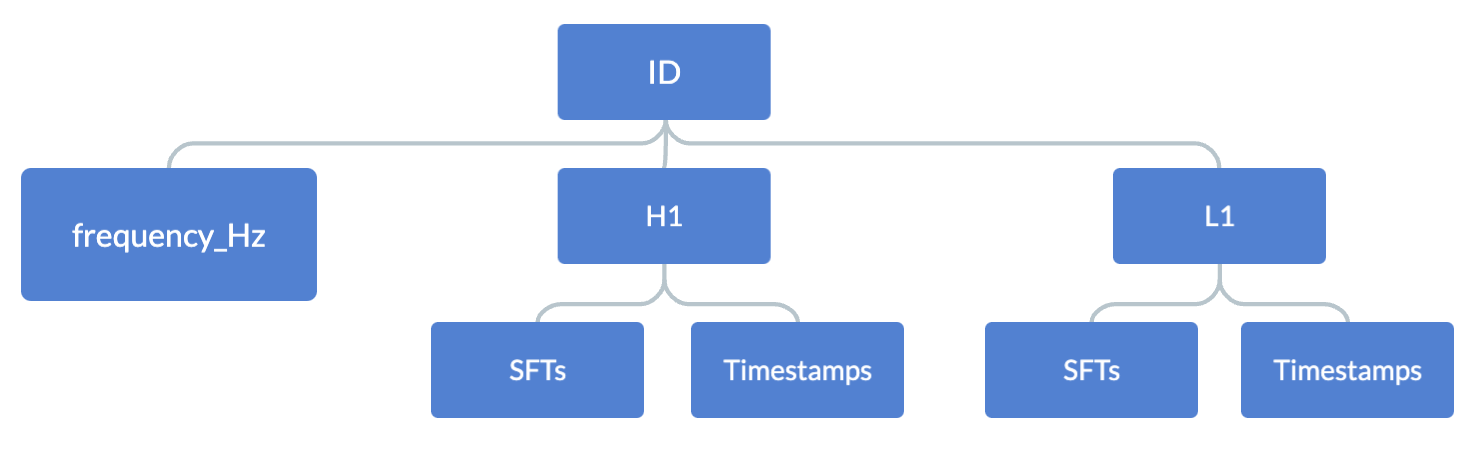

In [3]:
with h5py.File('../input/g2net-detecting-continuous-gravitational-waves/train/001121a05.hdf5', "r") as f:
    
    # get first object name/key; this is the data point ID
    ID_key = list(f.keys())[0]
    print(f"ID: {ID_key} \n")
    
    # Retrieve the Livingston decector data
    print(f"- {list(f[ID_key].keys())[1]}")
    
    L1_SFTs = f[ID_key]['L1']['SFTs']
    print(f"-- SFTs amplitudes shape: {L1_SFTs.shape}")
    
    L1_ts = f[ID_key]['L1']['timestamps_GPS']
    print(f"-- timestamps shape: {L1_ts.shape} \n")
    
    
    
    # Retrieve the Hanford decector data
    print(f"- {list(f[ID_key].keys())[0]}")
    H1_SFTs = f[ID_key]['H1']['SFTs']
    print(f"-- SFTs amplitudes shape: {H1_SFTs.shape}")
    
    H1_ts = f[ID_key]['H1']['timestamps_GPS']
    print(f"-- timestamps shape: {H1_ts.shape} \n")

    # Retrieve the frequency data
    freq_data = np.array(f[ID_key]['frequency_Hz'])
    print(f"- Frequency data shape: {freq_data.shape} \n")
    print(f"- Frequency data: {freq_data} \n")

ID: 001121a05 

- L1
-- SFTs amplitudes shape: (360, 4653)
-- timestamps shape: (4653,) 

- H1
-- SFTs amplitudes shape: (360, 4612)
-- timestamps shape: (4612,) 

- Frequency data shape: (360,) 

- Frequency data: [53.50777778 53.50833333 53.50888889 53.50944444 53.51       53.51055556
 53.51111111 53.51166667 53.51222222 53.51277778 53.51333333 53.51388889
 53.51444444 53.515      53.51555556 53.51611111 53.51666667 53.51722222
 53.51777778 53.51833333 53.51888889 53.51944444 53.52       53.52055556
 53.52111111 53.52166667 53.52222222 53.52277778 53.52333333 53.52388889
 53.52444444 53.525      53.52555556 53.52611111 53.52666667 53.52722222
 53.52777778 53.52833333 53.52888889 53.52944444 53.53       53.53055556
 53.53111111 53.53166667 53.53222222 53.53277778 53.53333333 53.53388889
 53.53444444 53.535      53.53555556 53.53611111 53.53666667 53.53722222
 53.53777778 53.53833333 53.53888889 53.53944444 53.54       53.54055556
 53.54111111 53.54166667 53.54222222 53.54277778 53.543

In [4]:
with h5py.File('../input/g2net-detecting-continuous-gravitational-waves/train/001121a05.hdf5', "r") as f:
    print(list(f.keys()))
    
    L1_SFTs = np.array(f["001121a05"]['L1']['SFTs'])
    print(f"-- SFTs amplitudes: {L1_SFTs}\n")
    
    L1_ts = np.array(f["001121a05"]['L1']['timestamps_GPS'])
    print(f"-- timestamps : {L1_ts} \n")
    for i in range(10):
        print(datetime.utcfromtimestamp(L1_ts[i]).strftime('%Y-%m-%d %H:%M:%S'))
    print(datetime.utcfromtimestamp(L1_ts[-1]).strftime('%Y-%m-%d %H:%M:%S'))

['001121a05']
-- SFTs amplitudes: [[ 1.64324296e-22-3.1472818e-23j -1.00137189e-22-1.4774891e-23j
  -6.60481177e-23-3.0084937e-23j ...  1.84227395e-22-5.1192286e-23j
   1.38055316e-22-1.1974054e-22j -4.09392714e-23+2.3366439e-22j]
 [ 5.36462208e-23+2.1168205e-22j  1.41085233e-23-5.7823479e-23j
  -1.47380586e-22-1.4218855e-23j ...  1.02693414e-22+1.1188245e-22j
   2.99236777e-23-1.8240328e-22j  1.20047893e-22-2.5860545e-23j]
 [-1.53539232e-23-1.0438731e-22j  3.30042963e-23-5.5109204e-23j
  -9.70230693e-23+8.4125358e-23j ... -6.28540703e-23-1.1867639e-22j
   1.62691707e-23+1.3417148e-22j -3.54630464e-23-6.3147445e-23j]
 ...
 [ 1.54795525e-23-5.6492803e-23j -3.87371283e-23+1.3568453e-23j
   6.71414663e-23+8.3919244e-23j ... -4.25969490e-23-1.8439974e-23j
   1.84349362e-23+1.6326568e-22j  6.31527520e-23-3.8267106e-23j]
 [-7.05851849e-23-2.3108510e-23j  4.53388970e-23-7.4036338e-23j
   9.91164127e-24+1.4265937e-22j ...  2.27643674e-23+2.1805239e-23j
  -6.87699150e-23-2.3973339e-23j  1.50314

So the x axis is time, which has 4k+ values, and on the y axis is the frequency. For every timestamp we have 360 values.

### Notes/explanation about the data

1) Each sample is of shape $(360,X)$, where $X>4000$. So the $x$-axis has 4000+ data points. Each of the 4000+ data points (timestamps) represents a date and time. Usually the consecutive timestamps are 30 minutes away, although this can vary.

2) Each timestamp has an array of size 360 associated with it. An array represents the Short-time Fourier Transforms (SFT) of the signal. So this means that at position 0 of the array, we have the power of frequency 1 Hz, at position 1 of the array, we have the power of frequency 2 Hz, and so on. Here is how we go from raw signal to SFT to spectrogram:

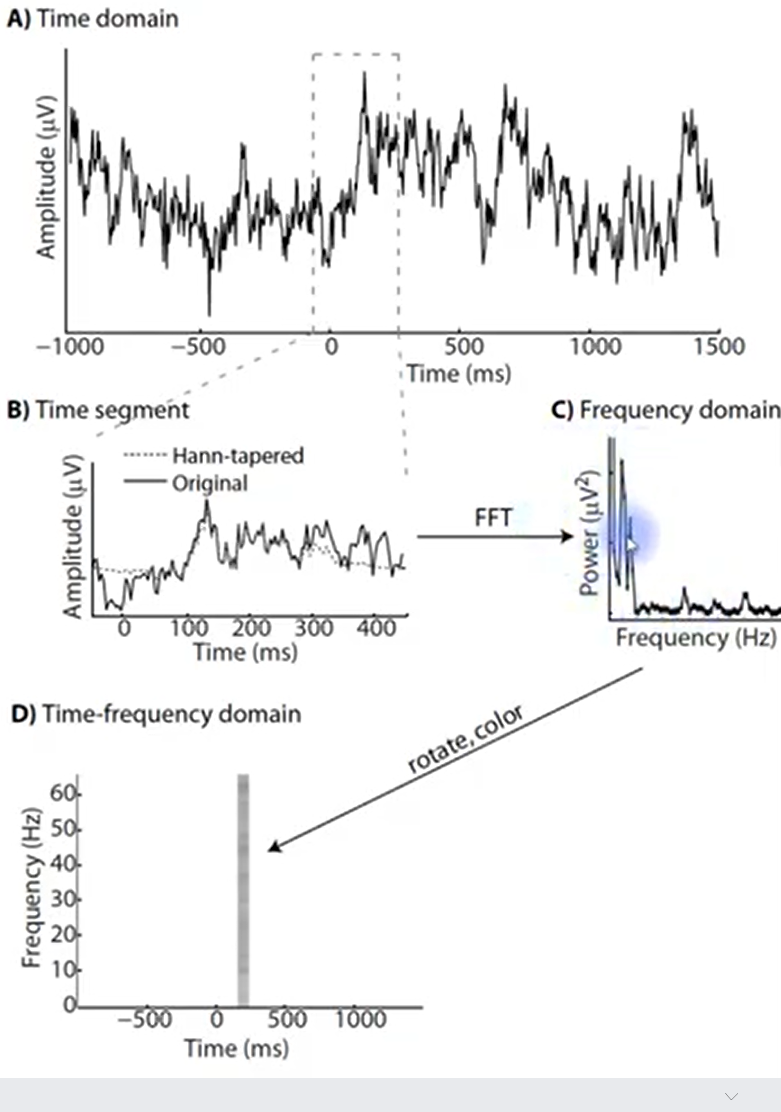



-

-

-

# Generating Data

-

-

-

# Modelling

Some code taken from [here](https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification).

In [5]:
# Train metadata
df = pd.read_csv('/kaggle/input/g2net-detecting-continuous-gravitational-waves/train_labels.csv')
df = df[df.target >= 0]  # Remove 3 unknowns (target = -1)

class Dataset(torch.utils.data.Dataset):
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
    img (np.float32): 2 x 360 x 128
    y (np.float32): label 0 or 1
    """
    def __init__(self, data_type, df):
        self.data_type = data_type
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        file_id = r.id

        img = np.empty((2, 360, 128), dtype=np.float32)
        filename = '%s/%s/%s.hdf5' % ('/kaggle/input/g2net-detecting-continuous-gravitational-waves', self.data_type, file_id)
        with h5py.File(filename, 'r') as f:
            g = f[file_id]

            for ch, s in enumerate(['H1', 'L1']):
                a = g[s]['SFTs'][:, :4096] * 1e22  # Fourier coefficient complex64

                p = np.sqrt(a.real**2 + a.imag**2)  # power 
                p /= np.mean(p)  # normalize
                p = np.mean(p.reshape(360, 128, 32), axis=2)  # compress 4096 -> 128

                img[ch] = p
        return img , y

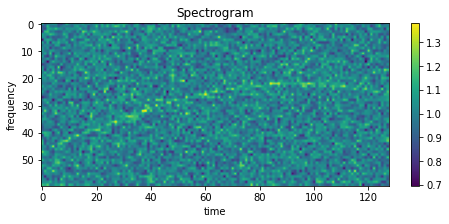

In [6]:
dataset = Dataset('train', df)
img, y = dataset[10]

plt.figure(figsize=(8, 3))
plt.title('Spectrogram')
plt.xlabel('time')
plt.ylabel('frequency')
plt.imshow(img[0,300:360])  # zooming in for dataset[10]
plt.colorbar()
plt.show()

In [23]:
class Model(nn.Module):
    def __init__(self, name, *, pretrained=False):
        """
        name (str): timm model name, e.g. tf_efficientnet_b2_ns
        """
        super().__init__()

        # Use timm
        model = timm.create_model(name, pretrained=pretrained, in_chans=2)

        clsf = model.default_cfg['classifier']
        n_features = model._modules[clsf].in_features
        model._modules[clsf] = nn.Identity()

        self.fc = nn.Linear(n_features, 1)
        self.model = model
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x =  self.fc(x)
        return self.sigm(x)

In [14]:
def evaluate(model, loader_val, *, compute_score=True):
    """
    Predict and compute loss and score
    """
    tb = time.time()
    was_training = model.training
    model.eval()

    loss_sum = 0.0
    n_sum = 0
    y_all = []
    y_pred_all = []


    for img, y in loader_val:
        n = y.size(0)
        img = img.to(device)
        y = y.to(device)

        with torch.no_grad():
            y_pred = model(img.to(device))
        loss = criterion(y_pred.view(-1), y)

        n_sum += n
        loss_sum += n * loss.item()

        y_all.append(y.cpu().detach().numpy())
        y_pred_all.append(y_pred.sigmoid().squeeze().cpu().detach().numpy())
#         print(f"y_pred.view(-1) {y_pred.view(-1)}")
#         print(f"y_pred_all {y_pred_all}")
#         print(f"img.shape {img.shape}")
#         print(f"y.shape {y.shape}")
        del loss, y_pred, img, y

    loss_val = loss_sum / n_sum

    y = np.concatenate(y_all)
    y_pred = np.concatenate(y_pred_all)

    score = roc_auc_score(y, y_pred) if compute_score else None

    ret = {'loss': loss_val,
           'score': score,
           'y': y,
           'y_pred': y_pred,
           'time': time.time() - tb}
    
    model.train(was_training)  # back to train from eval if necessary

    return ret

In [ ]:
# device = torch.device('cuda')
device = torch.device('cpu')
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()

model_name = 'tf_efficientnet_b2_ns'
nfold = 10
kfold = KFold(n_splits=nfold, random_state=42, shuffle=True)

epochs = 20
batch_size = 10
num_workers = 2
weight_decay = 1e-6
max_grad_norm = 1000

lr_max = 4e-4
epochs_warmup = 1.0

for ifold, (idx_train, idx_test) in enumerate(kfold.split(df)):
    print('Fold %d/%d' % (ifold, nfold))
    torch.manual_seed(42 + ifold + 1)

    # Train - val split
    dataset_train = Dataset('train', df.iloc[idx_train])
    dataset_val = Dataset('train', df.iloc[idx_test])

    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                     num_workers=num_workers, pin_memory=True, shuffle=True, drop_last=True)
    loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size,
                     num_workers=num_workers, pin_memory=True)

    # Model and optimizer
    model = Model(model_name, pretrained=True)
    model.to(device)
    model.train()

#     optimizer = torch.optim.AdamW(model.parameters(), lr=lr_max, weight_decay=weight_decay)
    optimizer = torch.optim.Adam(model.parameters(), lr= 10**(-2))
    # Learning-rate schedule
    nbatch = len(loader_train)
    warmup = epochs_warmup * nbatch  # number of warmup steps
    nsteps = epochs * nbatch        # number of total steps

#     scheduler = CosineLRScheduler(optimizer,
#                   warmup_t=warmup, warmup_lr_init=0.0, warmup_prefix=True, # 1 epoch of warmup
#                   t_initial=(nsteps - warmup), lr_min=1e-6)                # 3 epochs of cosine
    
    time_val = 0.0
    lrs = []

    tb = time.time()
    print('Epoch   loss          score   lr')
    current_best_score = 0
    for iepoch in range(epochs):
        loss_sum = 0.0
        n_sum = 0

        # Train
        for ibatch, (img, y) in enumerate(loader_train):
            n = y.size(0)
            img = img.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            y_pred = model(img.float())
            #loss = criterion(y_pred.view(-1), y)
            #print(y_pred)
            #print(y)
            loss = criterion(y_pred.squeeze(), y)
            
            loss_train = loss.item()
            loss_sum += n * loss_train
            n_sum += n

            loss.backward()

#            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),max_grad_norm)
            optimizer.step()
            
#             scheduler.step(iepoch * nbatch + ibatch + 1)
#             lrs.append(optimizer.param_groups[0]['lr'])            

        # Evaluate
        val = evaluate(model, loader_val)
        time_val += val['time']
        loss_train = loss_sum / n_sum
        lr_now = optimizer.param_groups[0]['lr']
        dt = (time.time() - tb) / 60
        print('Epoch %d %.4f %.4f %.4f  %.2e  %.2f min' % (iepoch + 1, loss_train, val['loss'], val['score'], lr_now, dt))
        if val['score'] > current_best_score:
            current_best_score = val['score']
            # Save model
            ofilename = 'model%d.pytorch' % ifold
            torch.save(model.state_dict(), ofilename)
            print(ofilename, 'written')

    dt = time.time() - tb
    print('Training done %.2f min total, %.2f min val' % (dt / 60, time_val / 60))


    break
    

Fold 0/10
Epoch   loss          score   lr


In [ ]:
plt.title('LR Schedule: Cosine with linear warmup')
plt.xlabel('steps')
plt.ylabel('learning rate')
plt.plot(lrs)
plt.show()

In [ ]:
# Load model (if necessary)
model = Model(model_name, pretrained=False)
filename = 'model0.pytorch'
model.to(device)
model.load_state_dict(torch.load(filename, map_location=device))
model.eval()

# Predict
submit = pd.read_csv('/kaggle/input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')
dataset_test = Dataset('test', submit)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=64,
                                          num_workers=num_workers, pin_memory=True)

test = evaluate(model, loader_test, compute_score=False)

# Write prediction
submit['target'] = test['y_pred']
submit.to_csv('submission.csv', index=False)